# Guide
## Data
[[Google Drive] /Data/Final/Step1.zip](https://drive.google.com/file/d/1W6cyqB21ewVnygA3lyKvNsQI0IxAEYFb/view?usp=sharing)
## Code
In [3] `base_dir` : 실제 데이터 경로로 변경 필요  
In [8] `filepath` : 학습된 모델 저장할 경로로 변경 필요  
In [21] `save_dir` : Grad-CAM 이미지 저장할 경로로 변경 필요
## Result
- Model  
[[Google Drive] /Final_Model/Step1_Model.h5](https://drive.google.com/file/d/1dHWgQP9FCqayUz2KN7TbxuFaGHThHUO0/view?usp=sharing)
- Grad-CAM  
[[Google Drive] /Grad-CAM/Step1.zip](https://drive.google.com/file/d/10wd2sgsuKEcfIdrRzvObLAD2YF7UWQ7P/view?usp=sharing)

---

# Purpose
- Step1 최종 모델 저장  
- 모델 성능 평가  

## Alternation
(compared to `9-3. Data_Added_SGD`)  
- 학습된 모델 저장  
- Confusion Matrix 출력  
- 잘못 분류한 테스트 데이터에 대한 Grad-CAM 출력 및 저장  

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import os

2024-11-22 09:12:56.426286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (400, 400)
batch_size = 32

In [3]:
# 데이터셋 로드
from tensorflow.keras.utils import image_dataset_from_directory

# 실제 데이터의 경로로 변경 필요
base_dir = "/tf/Fixed_Data/Data_Final/Step1"

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size)

Found 1930 files belonging to 2 classes.
Found 552 files belonging to 2 classes.
Found 278 files belonging to 2 classes.


2024-11-22 09:12:57.805644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:12:57.809846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 09:12:57.809962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# 모델 레이어 구성
inputs = keras.Input(shape=(400, 400, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 398, 398, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 398, 398, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496 

In [6]:
# 학습률 및 옵티마이저 설정
optimizer = optimizers.SGD(learning_rate=1e-4, momentum=0.9)

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # 검증 손실을 기준으로 학습 중단
    patience=5,               # 성능이 개선되지 않는 에포크 수 (5회 연속 개선 없을 시 중단)
    restore_best_weights=True # 최적의 가중치 복원
)

## Save Step1 Final Model
`ModelCheckpoint` 콜백 사용 → val_loss가 개선된 매 Epoch마다 모델 저장  

## Saved Model
[[Google Drive] /Final_Model/Step1_Model.h5](https://drive.google.com/file/d/1dHWgQP9FCqayUz2KN7TbxuFaGHThHUO0/view?usp=sharing)

### Source : 교재 코드 8-11

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/tf/Final/Step1_Model.h5",   # 모델 저장 경로 변경 필요
        save_best_only=True,   # val_loss가 개선될 때만 저장
        monitor="val_loss"
    ),
    early_stopping   # early_stopping 함께 콜백 파라미터로 전달
]

In [9]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=callbacks,   # ModelCheckpoint 및 early_stopping 설정
    batch_size=batch_size)

Epoch 1/100


2024-11-22 09:12:58.900364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-22 09:12:59.454780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-22 09:12:59.859375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-22 09:12:59.902557: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faf98dff7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 09:12:59.902586: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-22 09:12:59.944461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cl

61/61 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8036

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 11s 126ms/step - loss: 0.4298 - accuracy: 0.8036 - val_loss: 0.6619 - val_accuracy: 0.6703
Epoch 2/100
61/61 [==============================] - 7s 113ms/step - loss: 0.2698 - accuracy: 0.8829 - val_loss: 0.5446 - val_accuracy: 0.6938
Epoch 3/100
61/61 [==============================] - 7s 113ms/step - loss: 0.1892 - accuracy: 0.9223 - val_loss: 0.4479 - val_accuracy: 0.7717
Epoch 4/100
61/61 [==============================] - 7s 110ms/step - loss: 0.1496 - accuracy: 0.9394 - val_loss: 0.4266 - val_accuracy: 0.7645
Epoch 5/100
61/61 [==============================] - 7s 111ms/step - loss: 0.1290 - accuracy: 0.9503 - val_loss: 0.1939 - val_accuracy: 0.9239
Epoch 6/100
61/61 [==============================] - 7s 112ms/step - loss: 0.1115 - accuracy: 0.9570 - val_loss: 0.1899 - val_accuracy: 0.9293
Epoch 7/100
61/61 [==============================] - 7s 111ms/step - loss: 0.0820 - accuracy: 0.9751 - val_loss: 0.1764 - val_accuracy: 0.9312
Epoch 8/10

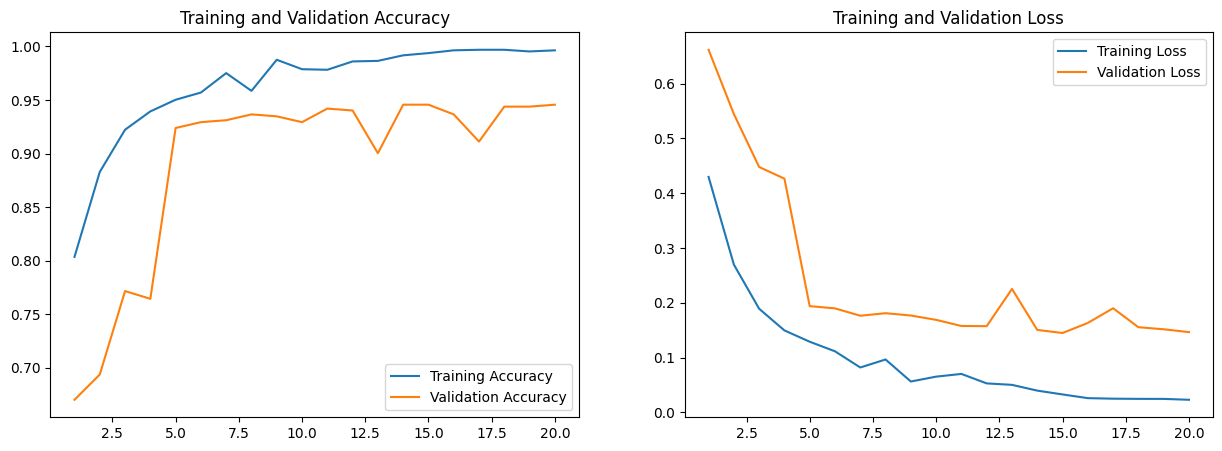

In [10]:
# 훈련 정확도와 손실 그래프 생성
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"test accuracy: {test_acc}")
print(f"test loss: {test_loss}")

9/9 [==============================] - 1s 48ms/step - loss: 0.1839 - accuracy: 0.9388
test accuracy: 0.9388489127159119
test loss: 0.1838623434305191


# Confusion Matrix
## Code Source
[[IBM] Create a confusion matrix with Python](https://developer.ibm.com/tutorials/awb-confusion-matrix-python/#confusion-matrix-layout0)

In [12]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import seaborn as sns

In [13]:
# 테스트 데이터 로드
# shuffle=False
test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 278 files belonging to 2 classes.


In [14]:
true_labels = []
predictions = []

# 테스트 데이터 실제 라벨, 예측 클래스 저장
for images, labels in test_dataset:
    # 모델 예측
    preds = model.predict(images)  # 확률 값 (0~1)
    
    predictions.extend((preds > 0.5).astype(int))  # 0.5 기준으로 클래스 변환
    true_labels.extend(labels.numpy())  # 실제 라벨 저장

# 리스트 변환
predictions = np.array(predictions).flatten()
true_labels = np.array(true_labels).flatten()

1/1 [==============================] - 0s 121ms/step


In [15]:
# define confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predictions)

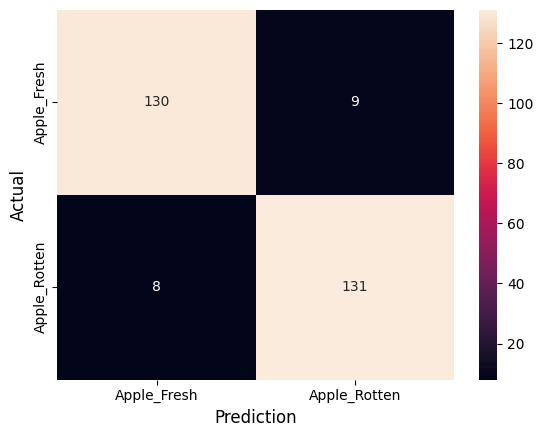

In [16]:
# define and print matrix with labels
sns.heatmap(confusion_matrix,
            annot=True,
            fmt='g',
            xticklabels=["Apple_Fresh", "Apple_Rotten"],
            yticklabels=["Apple_Fresh", "Apple_Rotten"])

# display matrix
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()

# Grad-CAM
잘못 예측한 이미지의 Grad-CAM 출력 및 저장

## Code Source
[[keras] Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)  

## Saved Image
[[Google Drive] /Grad-CAM/Step1.zip](https://drive.google.com/file/d/10wd2sgsuKEcfIdrRzvObLAD2YF7UWQ7P/view?usp=sharing)

In [17]:
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl

In [18]:
def get_img_array(img_path, size):
    
    # `img` is a PIL image of size 400x400
    img = keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (400, 400, 3)
    array = keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 400, 400, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [19]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output])


    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [20]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    print(f"Grad-CAM saved to: {cam_path}")

In [21]:
last_conv_layer_name = "conv2d_3"

save_dir = "/tf/Grad-CAM/Step1"   # Grad-CAM 이미지 저장 경로 변경 필요
test_dir = os.path.join(base_dir, 'test')

In [22]:
# 이미지 파일 경로 추출
file_paths = []
for root, _, files in os.walk(test_dir):
    for file in files:
        file_paths.append(os.path.join(root, file))

# 파일 경로 정렬 → 데이터셋 순서와 일치
file_paths.sort()

In [23]:
incorrect_files = []
incorrect_idx = []

for i in range(len(true_labels)):
    if true_labels[i] != predictions[i]:
        incorrect_files.append(file_paths[i])
        incorrect_idx.append(i)

real class : Fresh
predicted class : Stale


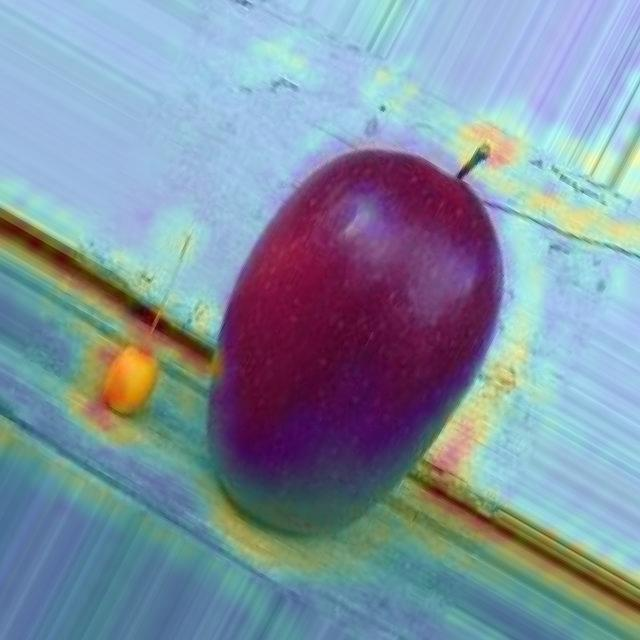

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_0_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_-00001_jpeg_jpg_09b54052-6447-4f12-804f-e5ca706966d5_0_8266.jpg

real class : Fresh
predicted class : Stale


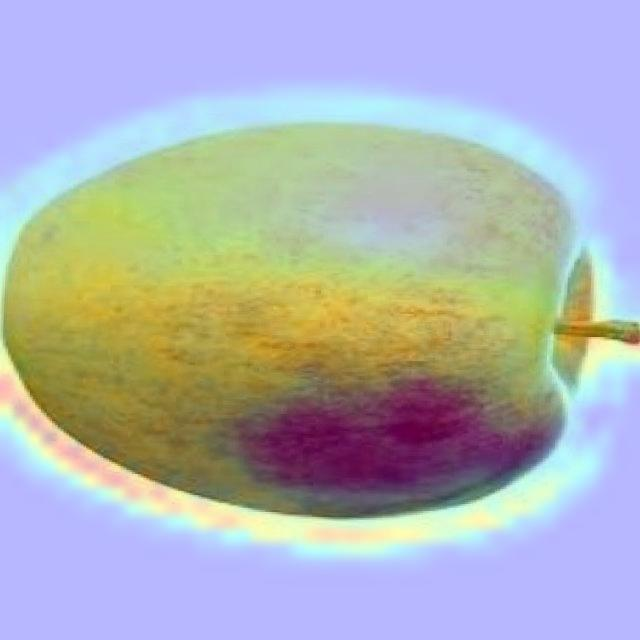

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_1_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_-00021_jpeg_jpg_0bb1f5af-5ed2-4a77-824b-7ca40daff2f3_0_8508.jpg

real class : Fresh
predicted class : Stale


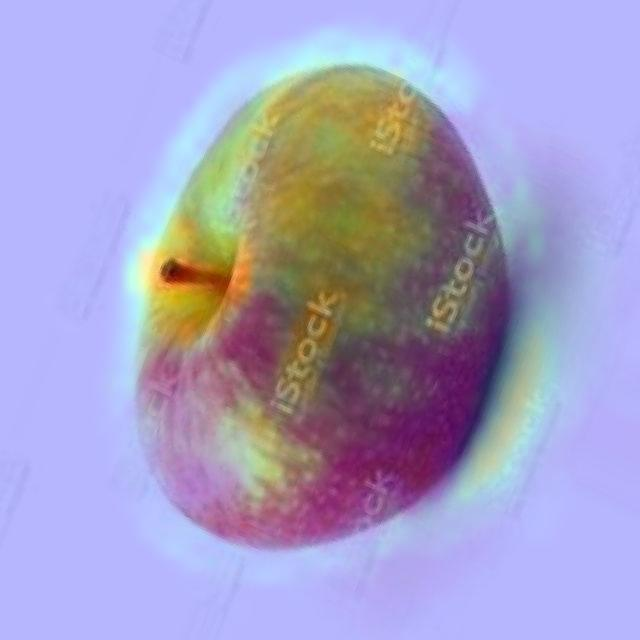

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_2_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_-00107_jpeg_jpg_e5d308ae-c9a5-4ef8-9ee2-b21f0b9d33e5_0_6767.jpg

real class : Fresh
predicted class : Stale


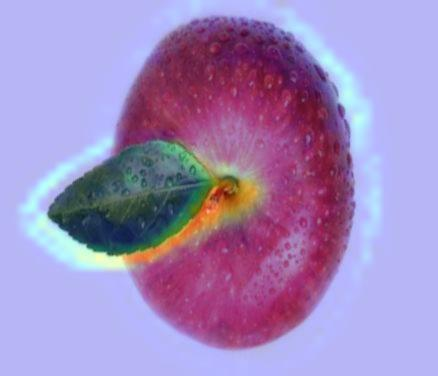

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_3_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_Screen Shot 2018-06-08 at 5_246d5dae-3f71-4be0-8363-2d3f5856dd50_0_6557.jpg

real class : Fresh
predicted class : Stale


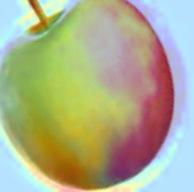

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_4_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_Screen Shot 2018-06-08 at 5_40d8d97d-a5a7-4cce-9154-1e8b8a27ed3e_0_446.jpg

real class : Fresh
predicted class : Stale


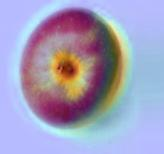

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_5_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_Screen Shot 2018-06-08 at 5_972fb06f-325b-4e30-81c2-abc7d76ed48b_0_156.jpg

real class : Fresh
predicted class : Stale


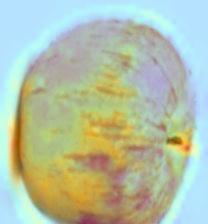

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_6_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/aug_Screen Shot 2018-06-08 at 5_e5be8f45-2274-44d9-bf5b-ad6b0b19d7d8_0_7349.jpg

real class : Fresh
predicted class : Stale


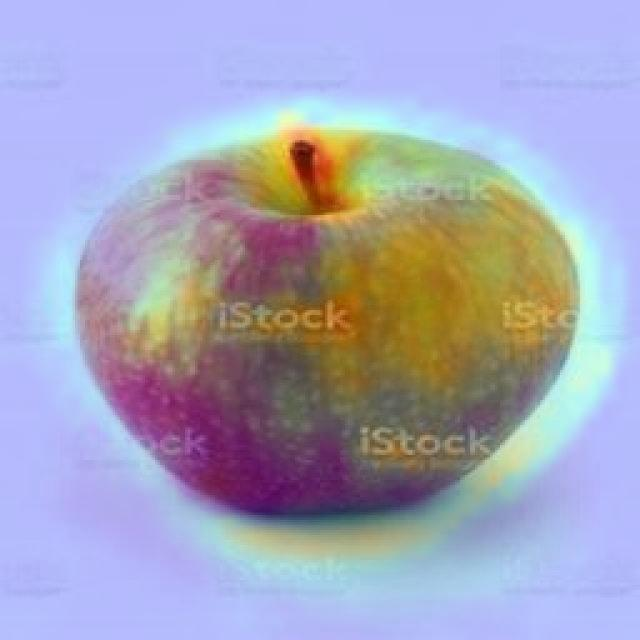

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_7_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/original_-00107_jpeg_jpg.rf.60d42f6c0afa704539e945fab54988b3.jpg

real class : Fresh
predicted class : Stale


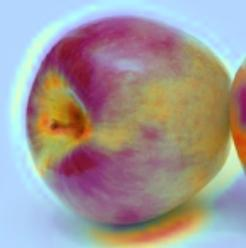

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_8_Fresh_to_Stale.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Fresh/original_Screen Shot 2018-06-08 at 5.33.33 PM.png

real class : Stale
predicted class : Fresh


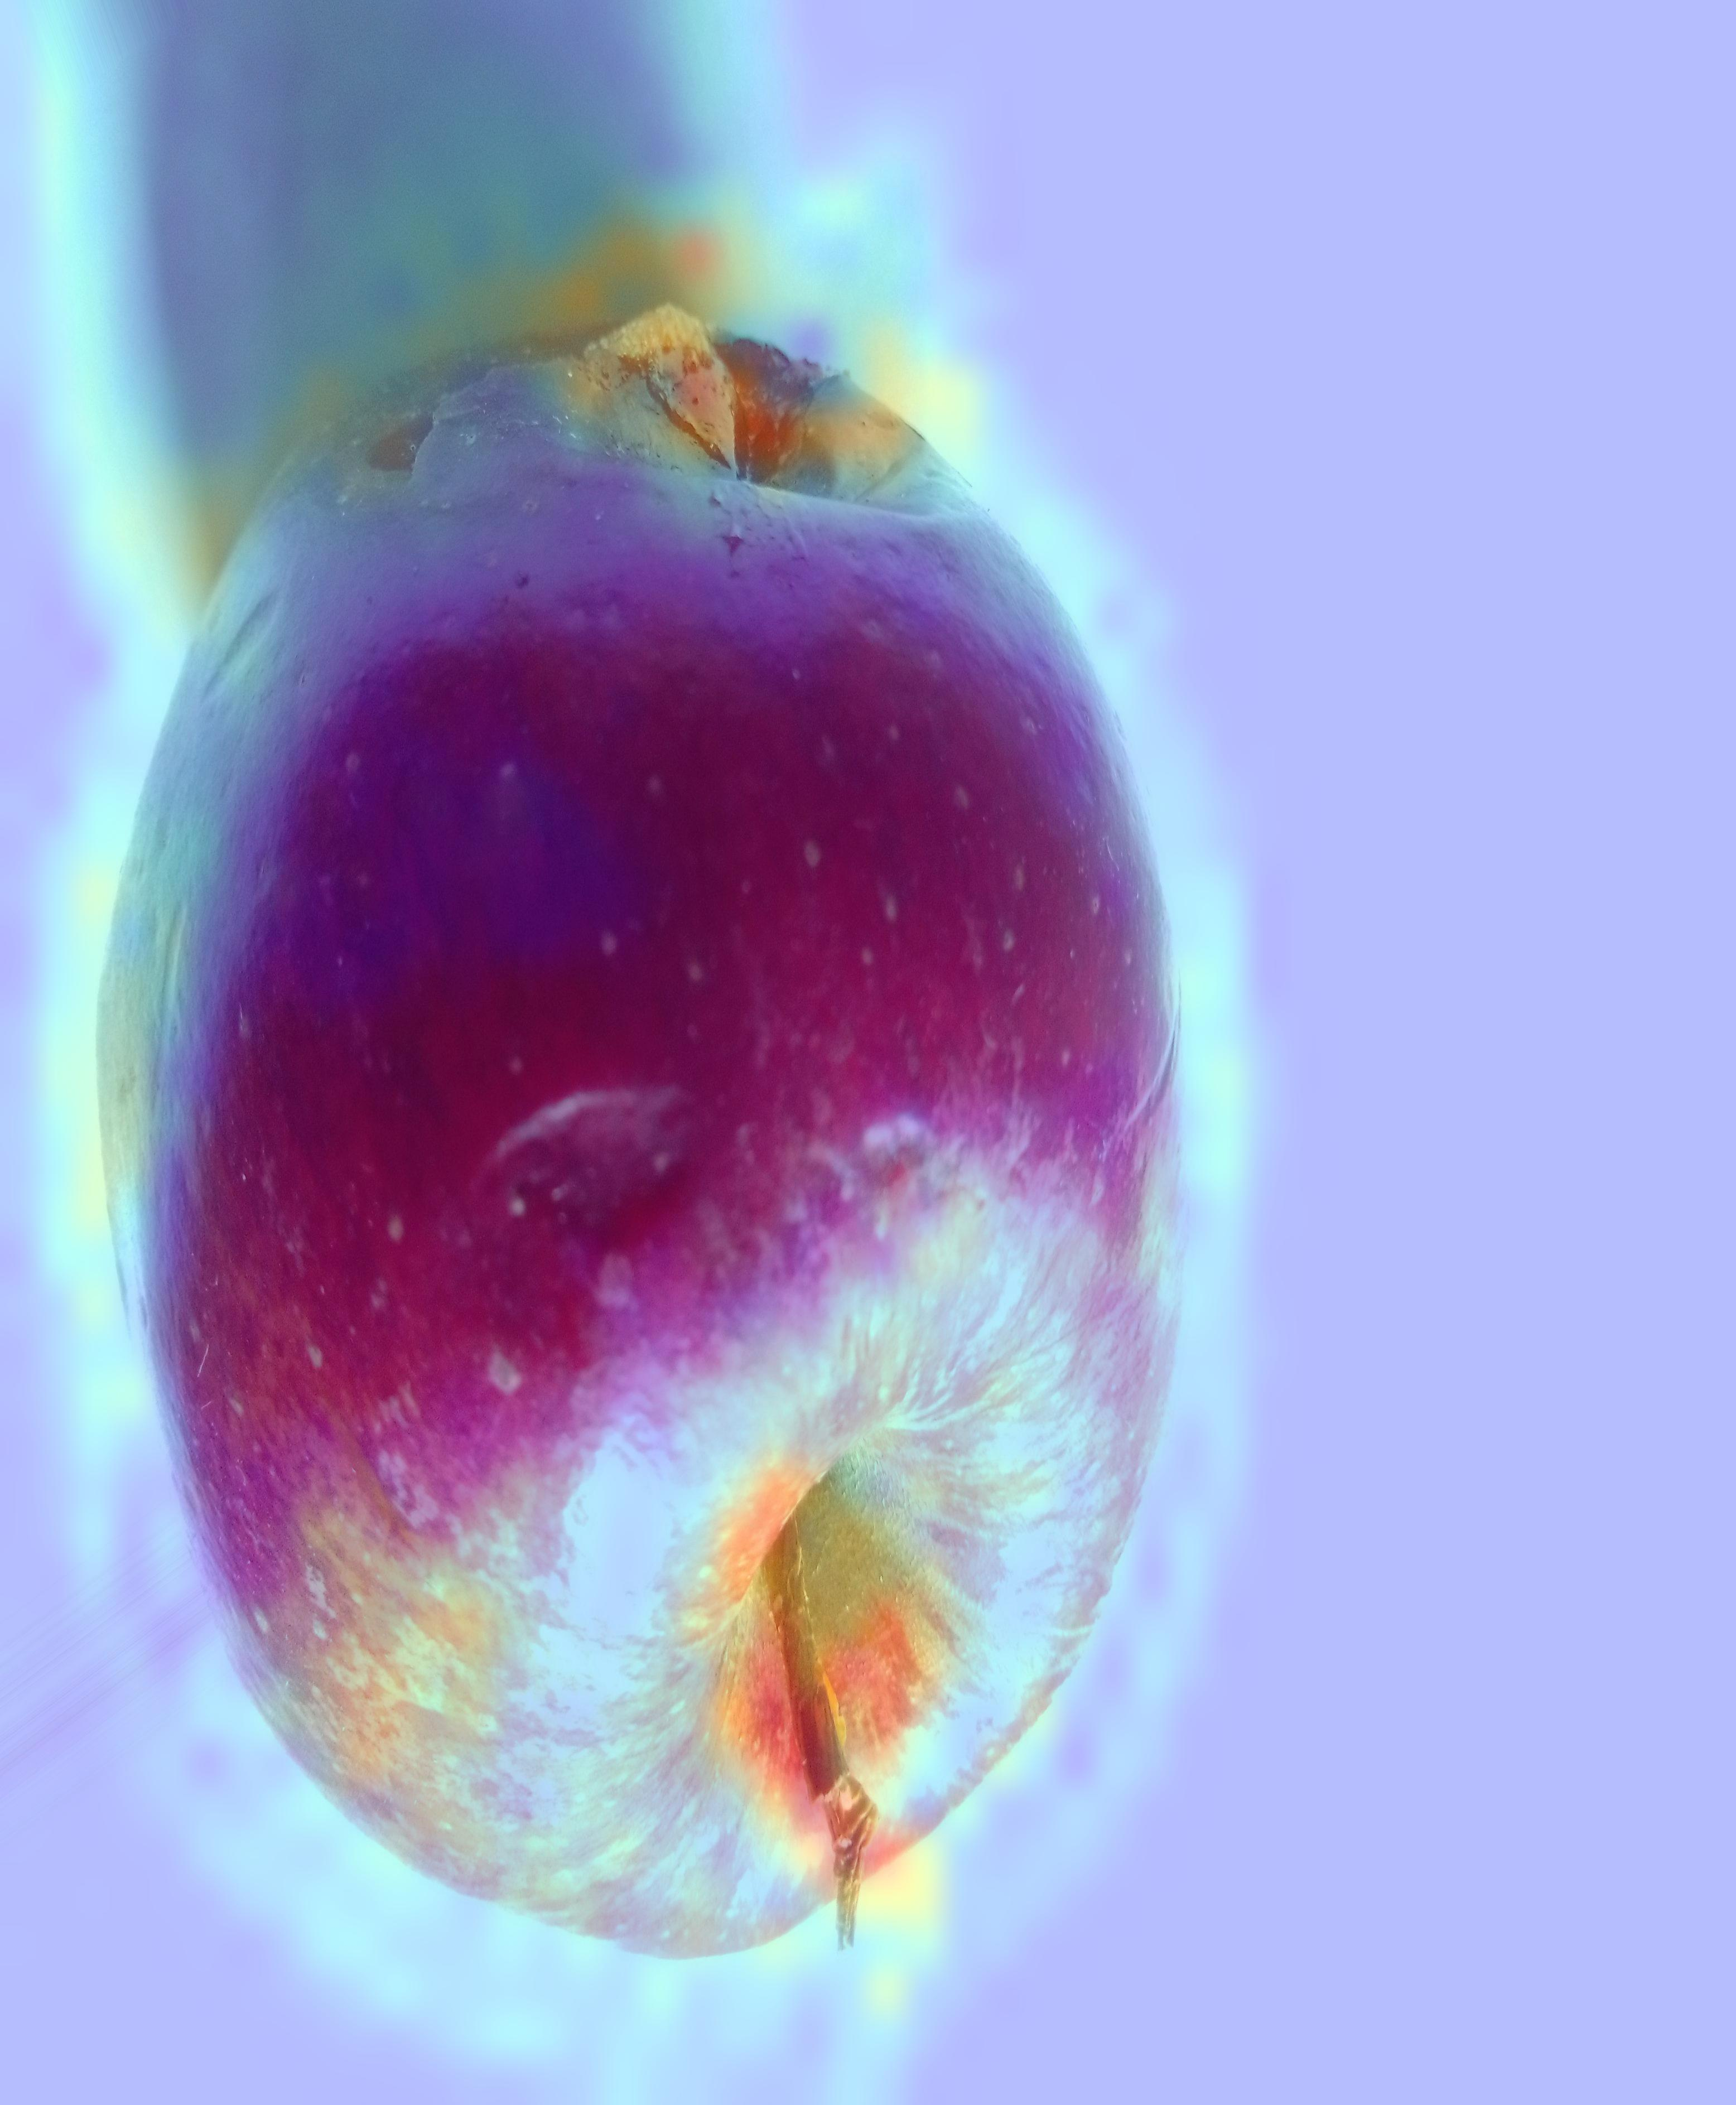

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_9_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_RottenApple (72)_9977d4ad-a3eb-42f7-994e-d43e40d50fad_0_7922.jpg

real class : Stale
predicted class : Fresh


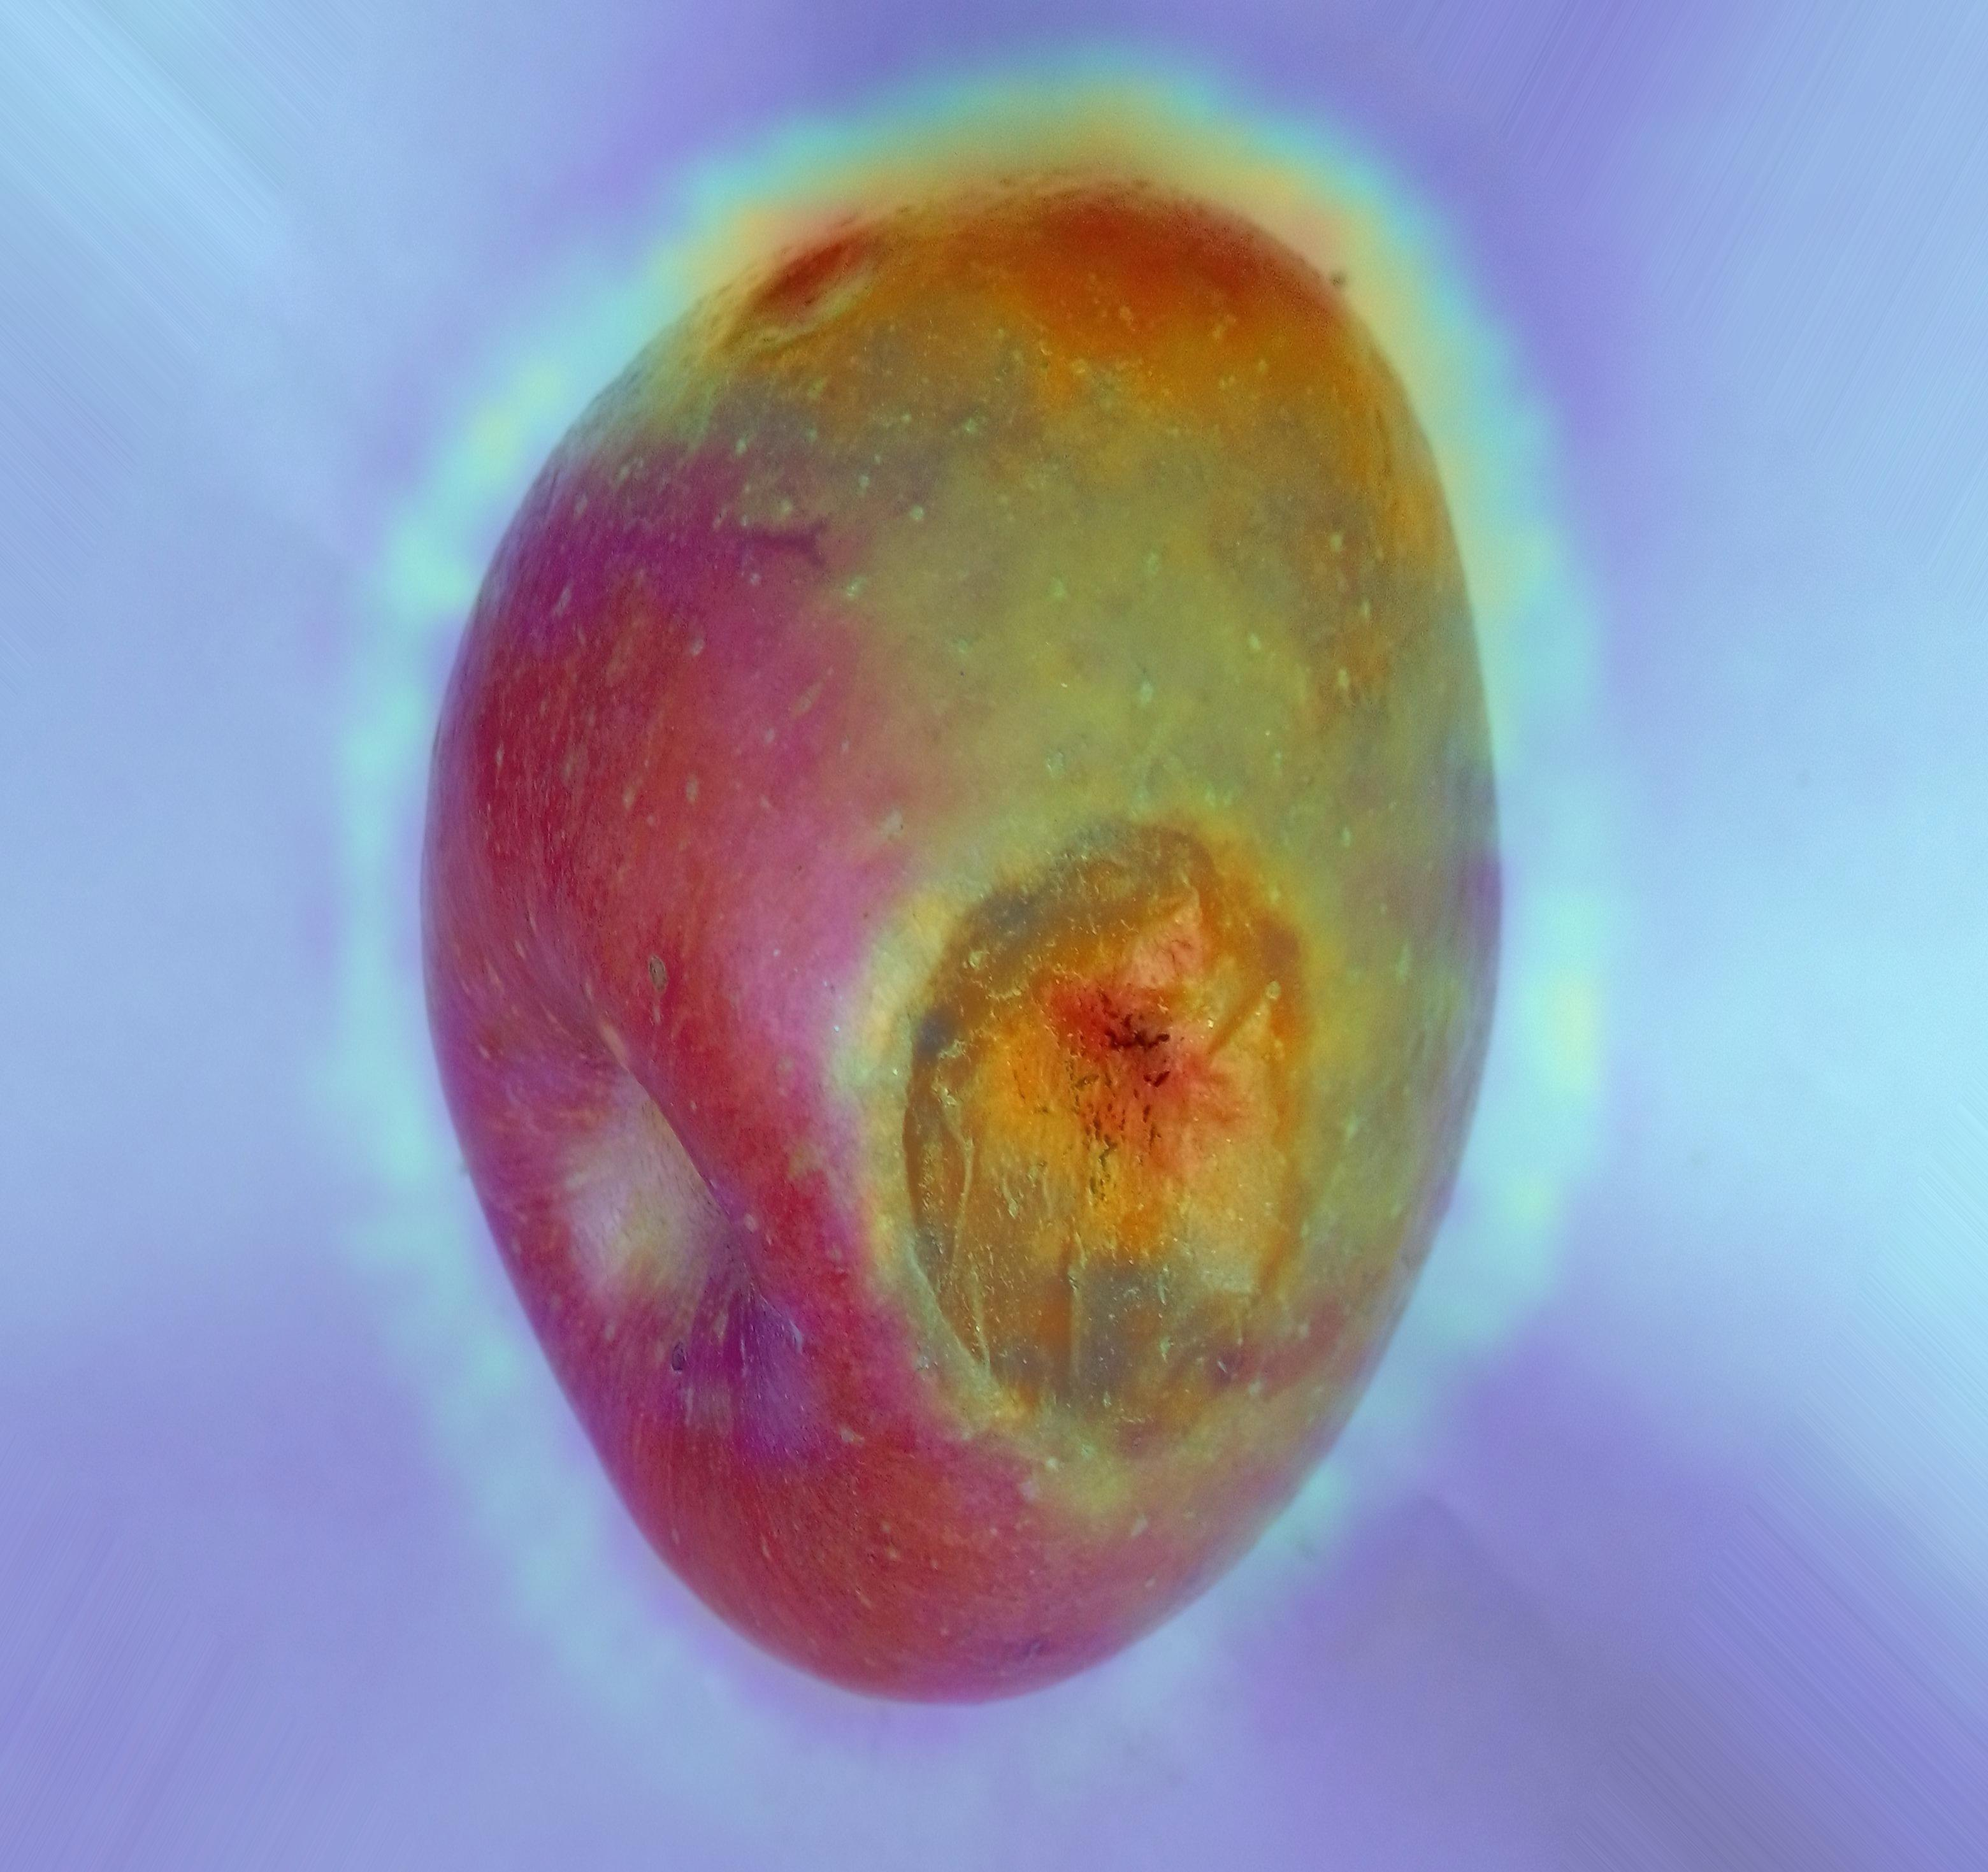

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_10_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_RottenApple (89)_26258ccc-9612-46d0-8c0e-9f3cf0398129_0_3582.jpg

real class : Stale
predicted class : Fresh


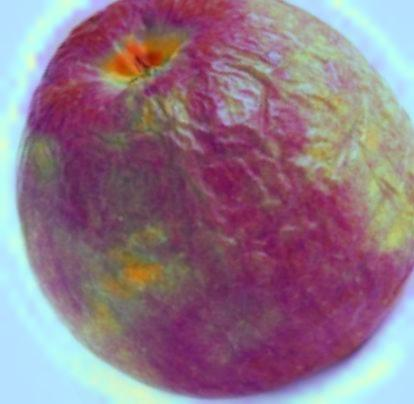

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_11_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_Screen Shot 2018-06-07 at 2_b52f304a-9f22-4512-943f-d1e8385b7da6_0_4363.jpg

real class : Stale
predicted class : Fresh


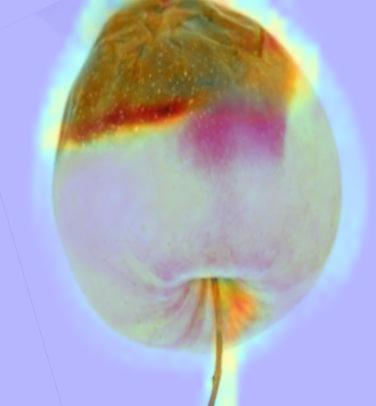

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_12_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_Screen Shot 2018-06-08 at 2_20ef8539-db09-4252-ac05-f8d952ace580_0_2339.jpg

real class : Stale
predicted class : Fresh


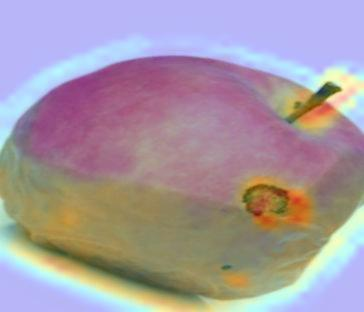

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_13_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_Screen Shot 2018-06-08 at 2_fb668e81-31c2-4ecb-ae73-bc1545e70687_0_4101.jpg

real class : Stale
predicted class : Fresh


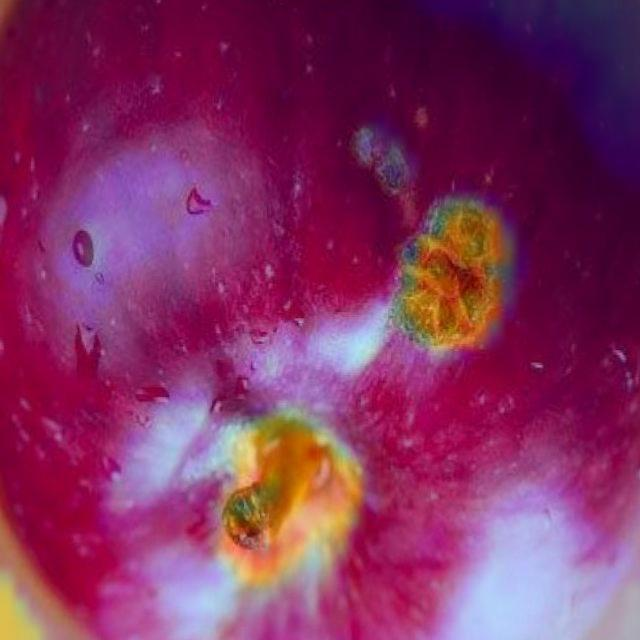

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_14_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/aug_img-375-_jpg_b4e472c3-5be5-4847-836f-657ce12350de_0_7364.jpg

real class : Stale
predicted class : Fresh


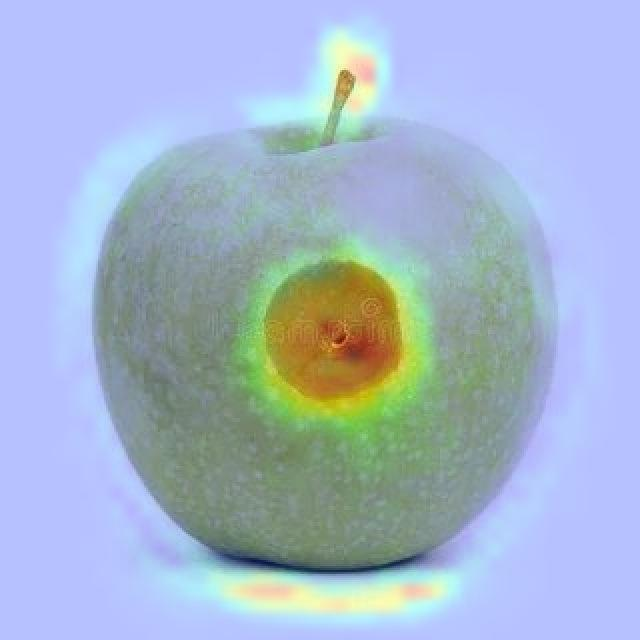

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_15_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/original_AQAD-r4xG0iHsEty_jpg.rf.c6c9377186b6fe07374dfe7fad14416e.jpg

real class : Stale
predicted class : Fresh


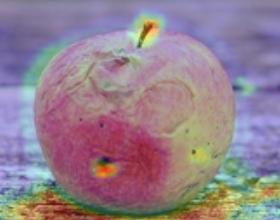

Grad-CAM saved to: /tf/Grad-CAM/Step1/Grad-CAM_16_Stale_to_Fresh.jpg
Original Image Path : /tf/Fixed_Data/Data_Final/Step1/test/Apple_Rotten/original_Screen Shot 2018-06-08 at 2.45.50 PM.png



In [24]:
idx = 0

for i in range(len(incorrect_idx)):
    
    img_path = incorrect_files[i]
    idx = incorrect_idx[i]
    
    # Prepare image
    img_array = get_img_array(img_path, size=image_size)

    # Remove last layer's sigmoid
    model.layers[-1].activation = None
    
    # Print what the real class is
    real = true_labels[idx]
    real = 'Fresh' if real == 0 else 'Stale'
    print(f"real class : {real}")

    # Print what the top predicted class is
    pred = predictions[idx]
    pred = 'Fresh' if pred < 0.5 else 'Stale'
    print(f"predicted class : {pred}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    cam_path = os.path.join(save_dir, f'Grad-CAM_{i}_{real}_to_{pred}.jpg')
    save_and_display_gradcam(img_path, heatmap, cam_path)
    print(f"Original Image Path : {img_path}")
    
    print()
    i += 1

# Analysis
## Fresh → Stale
주로 사과 꼭지 혹은 그림자를 상한 부분으로 인식하여 잘못 분류한 것으로 추정  
## Stale → Fresh
사과의 일부가 상하지 않고 전체적으로 쭈글한 경우 제대로 분류 못함  
증강 과정에서 이미지가 너무 확대되어 사과 전체를 배경, 상한 부분을 사과로 인식한 것으로도 보임  
Fresh → Stale의 경우와 반대로 상한 부분을 꼭지나 그림자로 인식했을 가능성도 있을 것으로 추정  

⇒ 꼭지/그림자와 상한 부분을 제대로 구분하지 못하는 듯함